## Data Reduction for Interpolation

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np


Earth radius information, from [this link](https://en.wikipedia.org/wiki/Earth_radius):
- Equatorial radius: a = (6378.1370 km)
- Polar radius: b = (6356.7523 km)

In [3]:
def spherical_to_cartesian(lat, lon, rad=False):
    '''
    Function to convert latitude and longitude coordinates into cartesian coordinate.
    
    Parameters
    ----------
    lat: float or ndarray
        Latitude angle(s)
    lon: float or ndarray
        Longitude angle(s)
    rad: bool (default: False)
        Indicate whether the specified angles are in radians.
    
    Returns
    -------
    (float, float, float) or (ndarray, ndarray, ndarray)
        Returns the x, y and z components of a unit vector in the direction of the latitude
        and longitude coordinate.
    
    '''
    if not rad:
        lat = np.deg2rad(lat)
        lon = np.deg2rad(lon)
    return np.cos(lat)*np.cos(lon), np.cos(lat)*np.sin(lon), np.sin(lat)



In [45]:
def no_iplot(func):
    '''Decorator to turn off and on the interactive mode in matplotlib'''
    def wrapper(*args, **kwargs):
        plt.ioff()
        func(*args, **kwargs)
        plt.ion()
    return wrapper

@no_iplot
def get_coord_around_pt(lat_array:np.ndarray, lon_array:np.ndarray, c_lat:float, c_lon:float,
                        R_tspot:float, R_earth:float=6378, plot:bool=False, ax=None):
    '''
    Function that, for a given array of existing latitude and longitude coordinates, 
    determines the subset of coordinates that are within a particular ditance from 
    a central coordinate.
    
    Parameters
    ----------
    lat_array: np.ndarray
        Numpy array (1D) of existing latitude coordinates.
    lon_array: np.ndarray
        Numpy array (1D) of existing longitude coordinates.
    c_lat: float
        Latitude coordinate of centre coordinate.
    c_lon: float
        Longitude coordinate of centre coordinate.
    R_tspot: float
        Largest acceptable distance from centre point, in Km. Translates to radius 
        of target spot.
    R_earth: float (assumed 6378 Km)
        Radius of the Earth, assumed constant.
    plot: bool (False by default)
        Determine whether to plot the target spot in a world map.
    ax: matplotlib axes object (None by default)
        Pass the axes on which to plot the target spot. Only useful if
        bool is set to True. If not provided, a new axes is generated.
    
    Returns
    -------
    tlat, tlon : np.ndarray
        Existing latitude and longitude coordinates that are within R_tspot 
        distance from the centre coordinate. Both are one-dimensional arrarys.    
    '''
    gamma = R_tspot / R_earth # characteristic angle of cone, in radians

    lon, lat = np.meshgrid(lon_array, lat_array)

    c_vec = np.array(spherical_to_cartesian(c_lat, c_lon))
    u = np.array(spherical_to_cartesian(lat, lon))
    u = np.rollaxis(u, 0, 3)

    angles = np.arccos(np.inner(u, c_vec))
    condition = angles < gamma
    tlat = lat[condition]
    tlon = lon[condition]
    
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 8))
            earth = Basemap()
    
        grid_style = {'linewidth': 0.2, 'dashes':[1,0], 'labels':[1, 1, 1, 1], 'labelstyle':'+/-'}
        earth.drawcoastlines(color='#555566', linewidth=1, ax=ax)
        # earth.plot(lon.reshape(-1), lat.reshape(-1), 'k.', alpha=0.5 ,latlon=True, ax=ax)
        arg_order = np.argsort(tlon)

        earth.plot(tlon[arg_order], tlat[arg_order], 'g.', latlon=True, ax=ax, alpha=0.6)
        earth.plot(c_lon, c_lat, 'ro', latlon=True, ax=ax)
                
        earth.drawmeridians(np.arange(-180, 181, 20), **grid_style, ax=ax)
        earth.drawparallels(np.arange(-90, 91, 30), **grid_style, ax=ax)
  
    return tlat, tlon


(array([-89.5, -89.5, -89.5, ..., -69.5, -69.5, -69.5]),
 array([-179.5, -178.5, -177.5, ...,   83.5,   84.5,   85.5]))

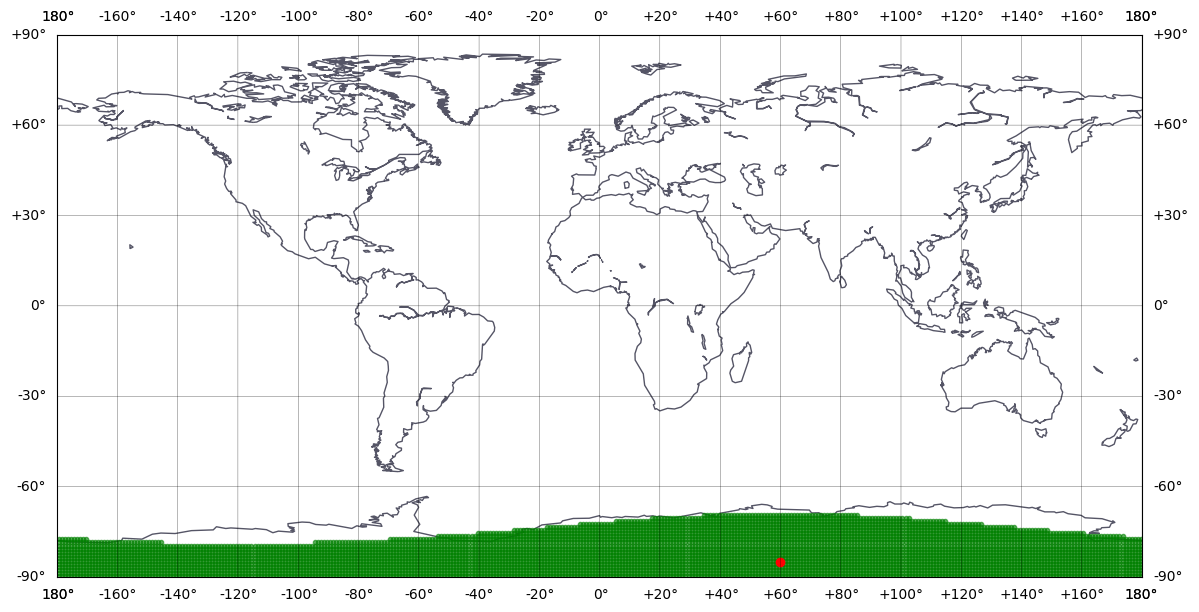

In [57]:
lon_ = np.arange(-179.5, 179.5+1, 1)
lat_ = np.arange(-89.5, 89.5+1, 1)
c_lat, c_lon = -85, 60


tlat, tlon = get_coord_around_pt(lat_, lon_, c_lat, c_lon, R_tspot=1800, plot=True)
tlat, tlon

In [56]:
R_tspot = 1500
R_earth = 6378
c_lat, c_lon = 0, 180
gamma = R_tspot / R_earth # characteristic angle of cone, in radians

lat_array = np.linspace(-20, 20, 9)

lon_array = np.linspace(170, 180, 3)
lon_array = np.concatenate((lon_array, -lon_array[::-1]))

lon, lat = np.meshgrid(lon_array, lat_array)

c_vec = np.array(spherical_to_cartesian(c_lat, c_lon))
u = np.array(spherical_to_cartesian(lat, lon))


u = np.rollaxis(u, 0, 3)

angles = np.arccos(np.inner(u, c_vec))
condition = angles < gamma
tlat = lat[condition]
tlon = lon[condition]
condition, tlat, tlon

arg_order = np.argsort(tlon)
tlon, tlat


(array([ 175.,  180., -180., -175.,  170.,  175.,  180., -180., -175.,
        -170.,  170.,  175.,  180., -180., -175., -170.,  170.,  175.,
         180., -180., -175., -170.,  175.,  180., -180., -175.]),
 array([-10., -10., -10., -10.,  -5.,  -5.,  -5.,  -5.,  -5.,  -5.,   0.,
          0.,   0.,   0.,   0.,   0.,   5.,   5.,   5.,   5.,   5.,   5.,
         10.,  10.,  10.,  10.]))

In [ ]:
import re
import os
import moviepy.editor as mpy
from directory_paths import illegal_char




# day = re.sub(illegal_char, '-', time_date.split()[-1])

fps=4

image_files = [os.path.join(plot_dir,img)
               for img in os.listdir(plot_dir)
               if img.endswith(".png")]
clip = mpy.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(os.path.join(plot_dir, f'{day}.mp4'))
clip.close()